In [2]:
# | hidden: true
# | echo: false
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

In the introductory lecture, we talked about the role of inference: drawing more general conclusions (about a population) from specific observations (a sample). Now that we have covered the most important building blocks, we can start to actually talk about how to make statistical inferences.

### The burden of proof
How can we use statistics to "prove" something? In diverse domains ranging from politics to sports, people often cite data as evidence. They may cherry-pick data that appears to support their argument, often constructing charts that highlight the point they want to make. You might hear data-grounded statements like "the unemployment rate is lower than it was 4 years ago" or "player X has the highest scoring average in the league". These statistical facts can sound iron-clad, but they ignore the complexity of the underlying data and the uncertainty therein. They typically fail to acknowledge aspects of the data that do not support their argument, and they are rarely transparent about how the data was collected or analyzed. 

For example, a politician might claim that their policies have led to a reduction in unemployment. Their support for this claim might be primarily based on a single statistic: "the unemployment rate is lower than it was 4 years ago". However, this statement does not provide any context or evidence that the politician's policies are actually responsible for the change. 

Let's look at unemployment data from the US Bureau of Labor Statistics (BLS) ^[from [here](https://data.bls.gov/dataQuery/find?fq=survey:%5Bln%5D&s=popularity:D), accessed July 2025]

In [3]:
# | hidden: true
# | echo: false
# | eval: false
# data from https://data.bls.gov/dataQuery/find?fq=survey:%5Bln%5D&s=popularity:D
data = pd.read_csv("~/Downloads/file.csv")
data.to_csv("../data/unemployment-data-raw.csv", index=False)
series_id_map = {
    "LNS12300000": "unadj-unemployment-all",
    "LNS13024887": "seas-unemployment-16-24",
    "LNS14000000": "seas-unemployment-all",
    "LNS14000003": "seas-unemployment-white",
    "LNS14000006": "seas-unemployment-black",
    "LNS14000009": "seas-unemployment-hispanic",
    "LNU04000000": "seas-employment-population-all",
}
data["series_name"] = data["Series ID"].map(series_id_map)
data = data.rename(
    columns={
        "Series ID": "series_id",
        "Year": "year",
        "Period": "period",
        "Value": "value",
        "Label": "label",
    }
)
data["month"] = data["period"].str.replace("M", "").astype(int)
data = data.drop(columns=["period"])
data["date"] = pd.to_datetime(data[["year", "month"]].assign(day=1))
data.to_csv("../data/unemployment-data-cleaned.csv", index=False)

(0.0, 8.0)

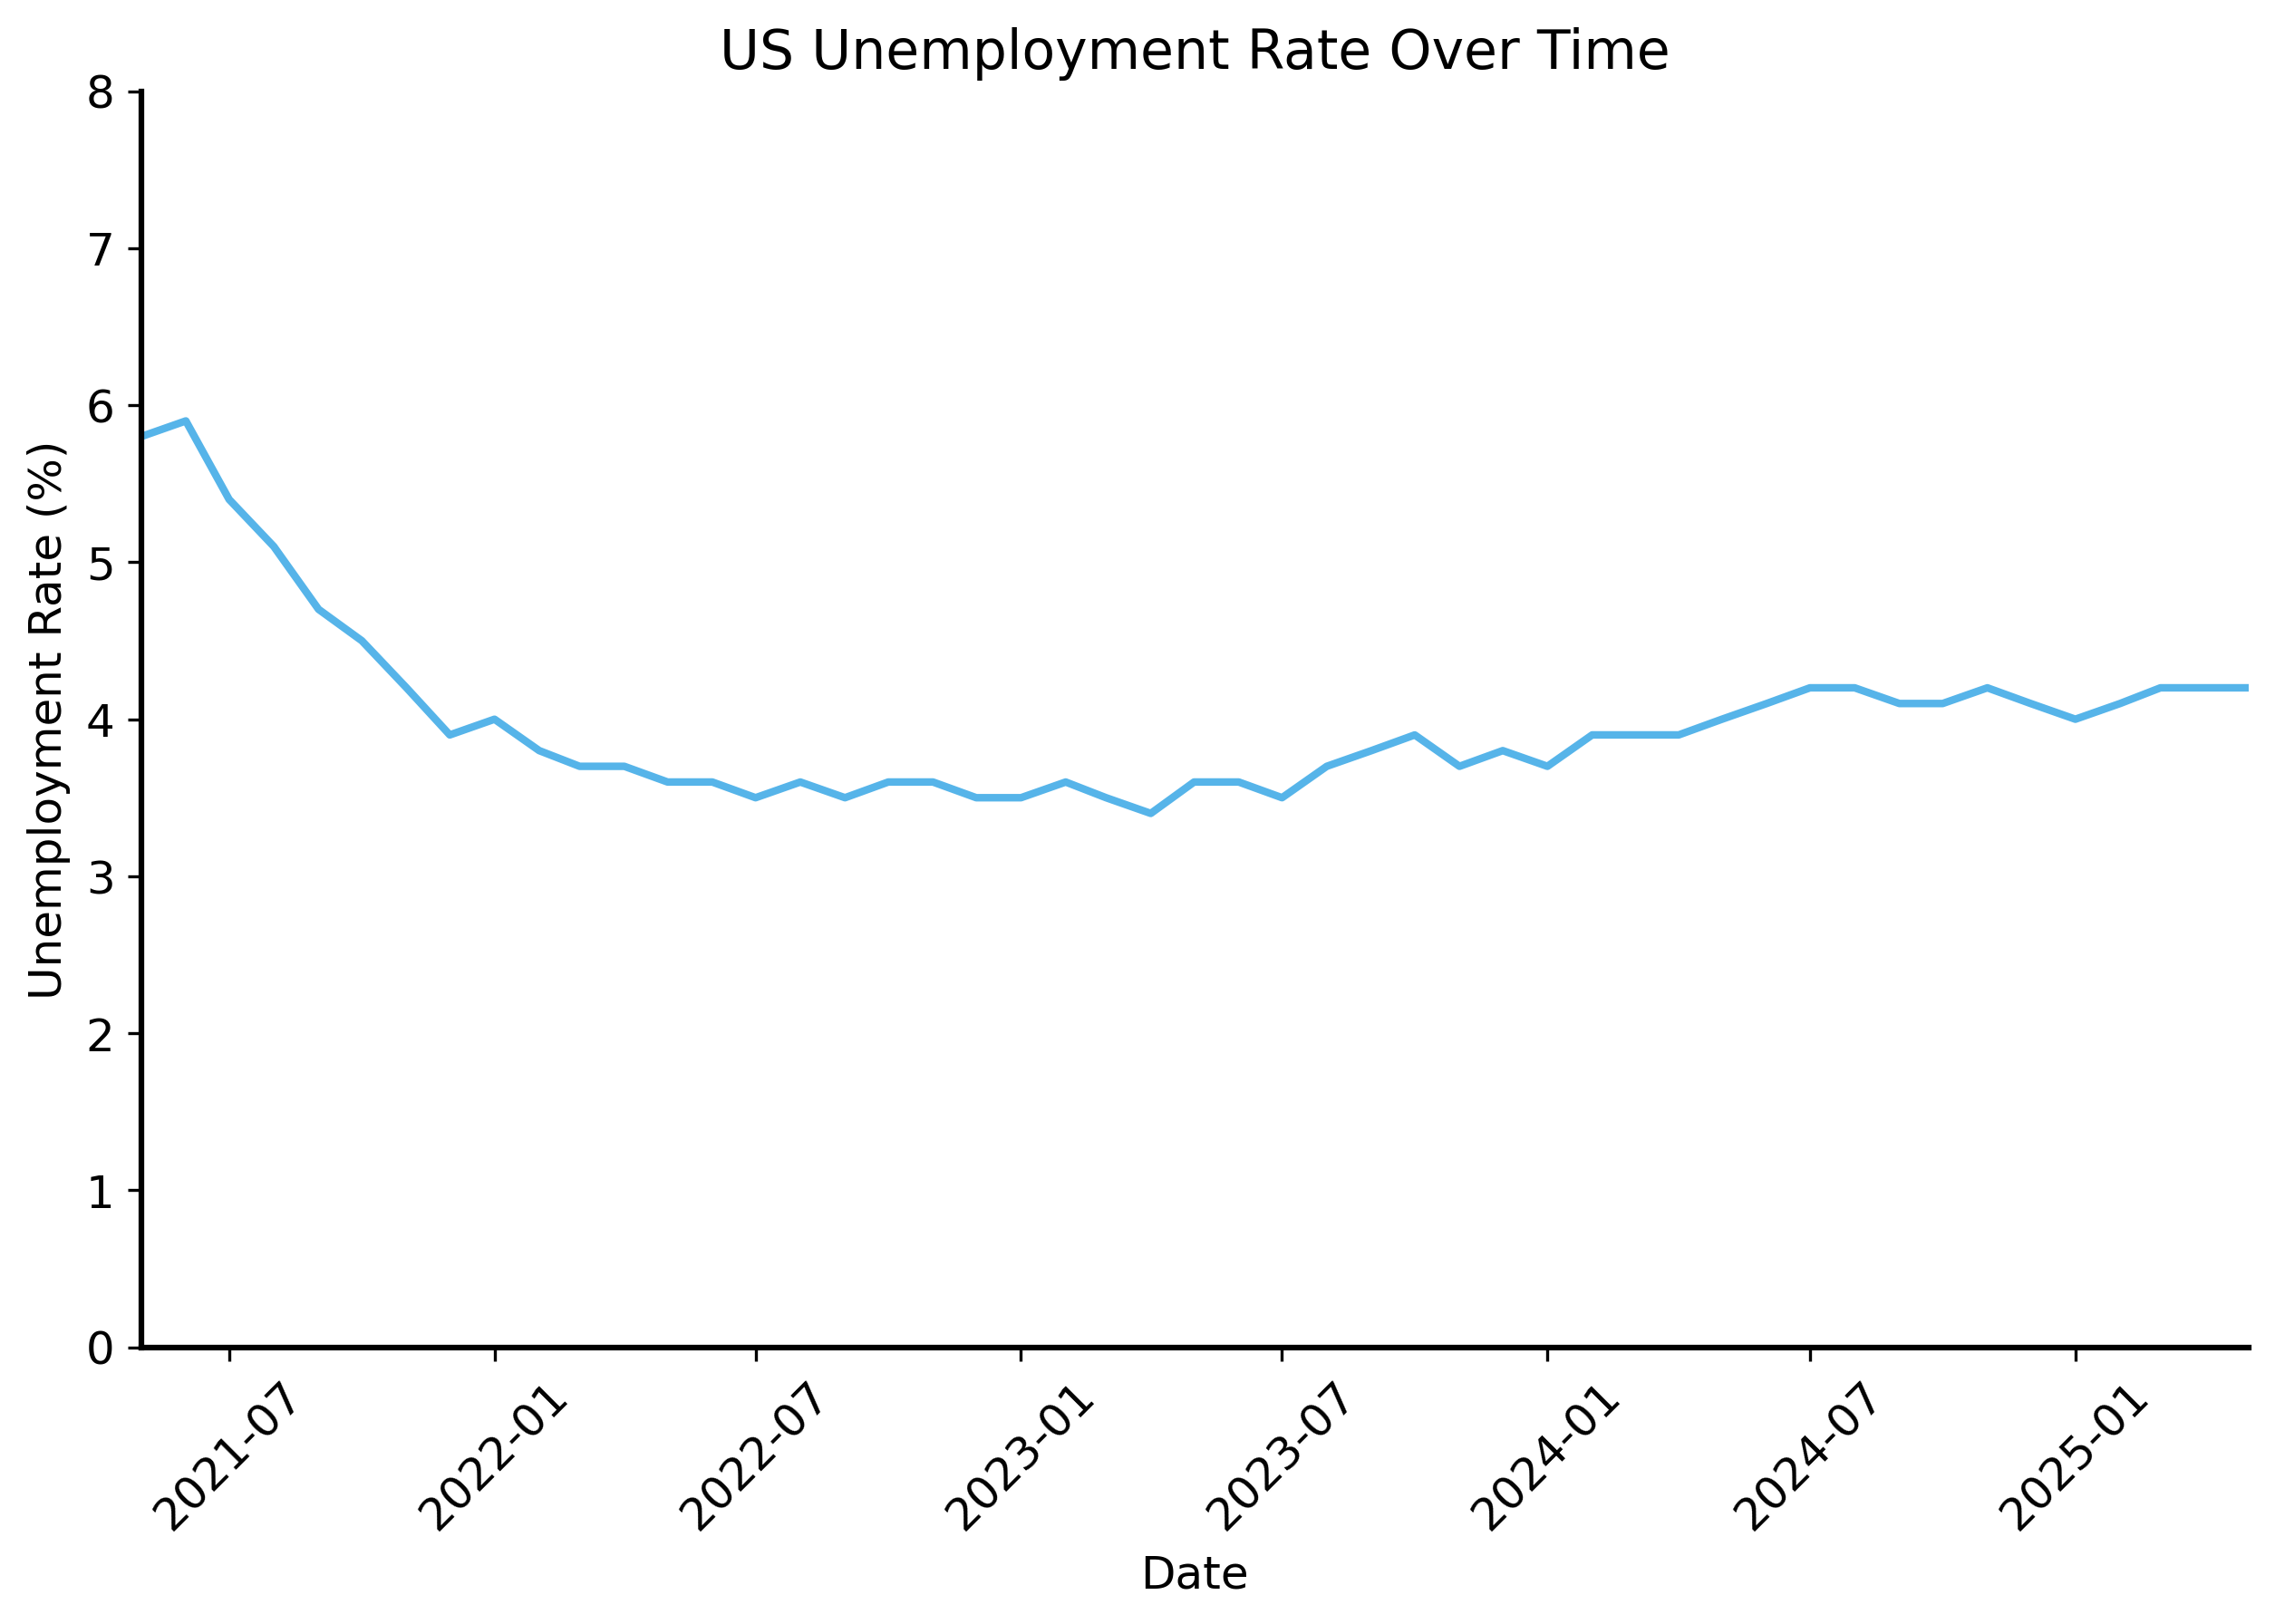

In [4]:
import datetime

data = pd.read_csv("../data/unemployment-data-cleaned.csv", parse_dates=["date"])
# pivot the data to have dates as index and series names as columns
wide_data = data.pivot(index="date", columns="series_name", values="value")

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=wide_data,
    x="date",
    y="seas-unemployment-all",
)
# format the x-axis to show dates nicely
plt.xticks(rotation=45)
plt.title("US Unemployment Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.xlim(datetime.date(2021, 5, 1), datetime.date(2025, 5, 1))
plt.ylim(0, 8)

What do you think? Are you convinced by the data presented? There's a pretty clear trend showing that unemployment decreased, as the politician claimed. It has basically leveled off in the last few years, but it is still lower than it was 4 years ago. 

To see one of the many things that the politician is not telling you, let's look at the unemployment rate over a longer time period.

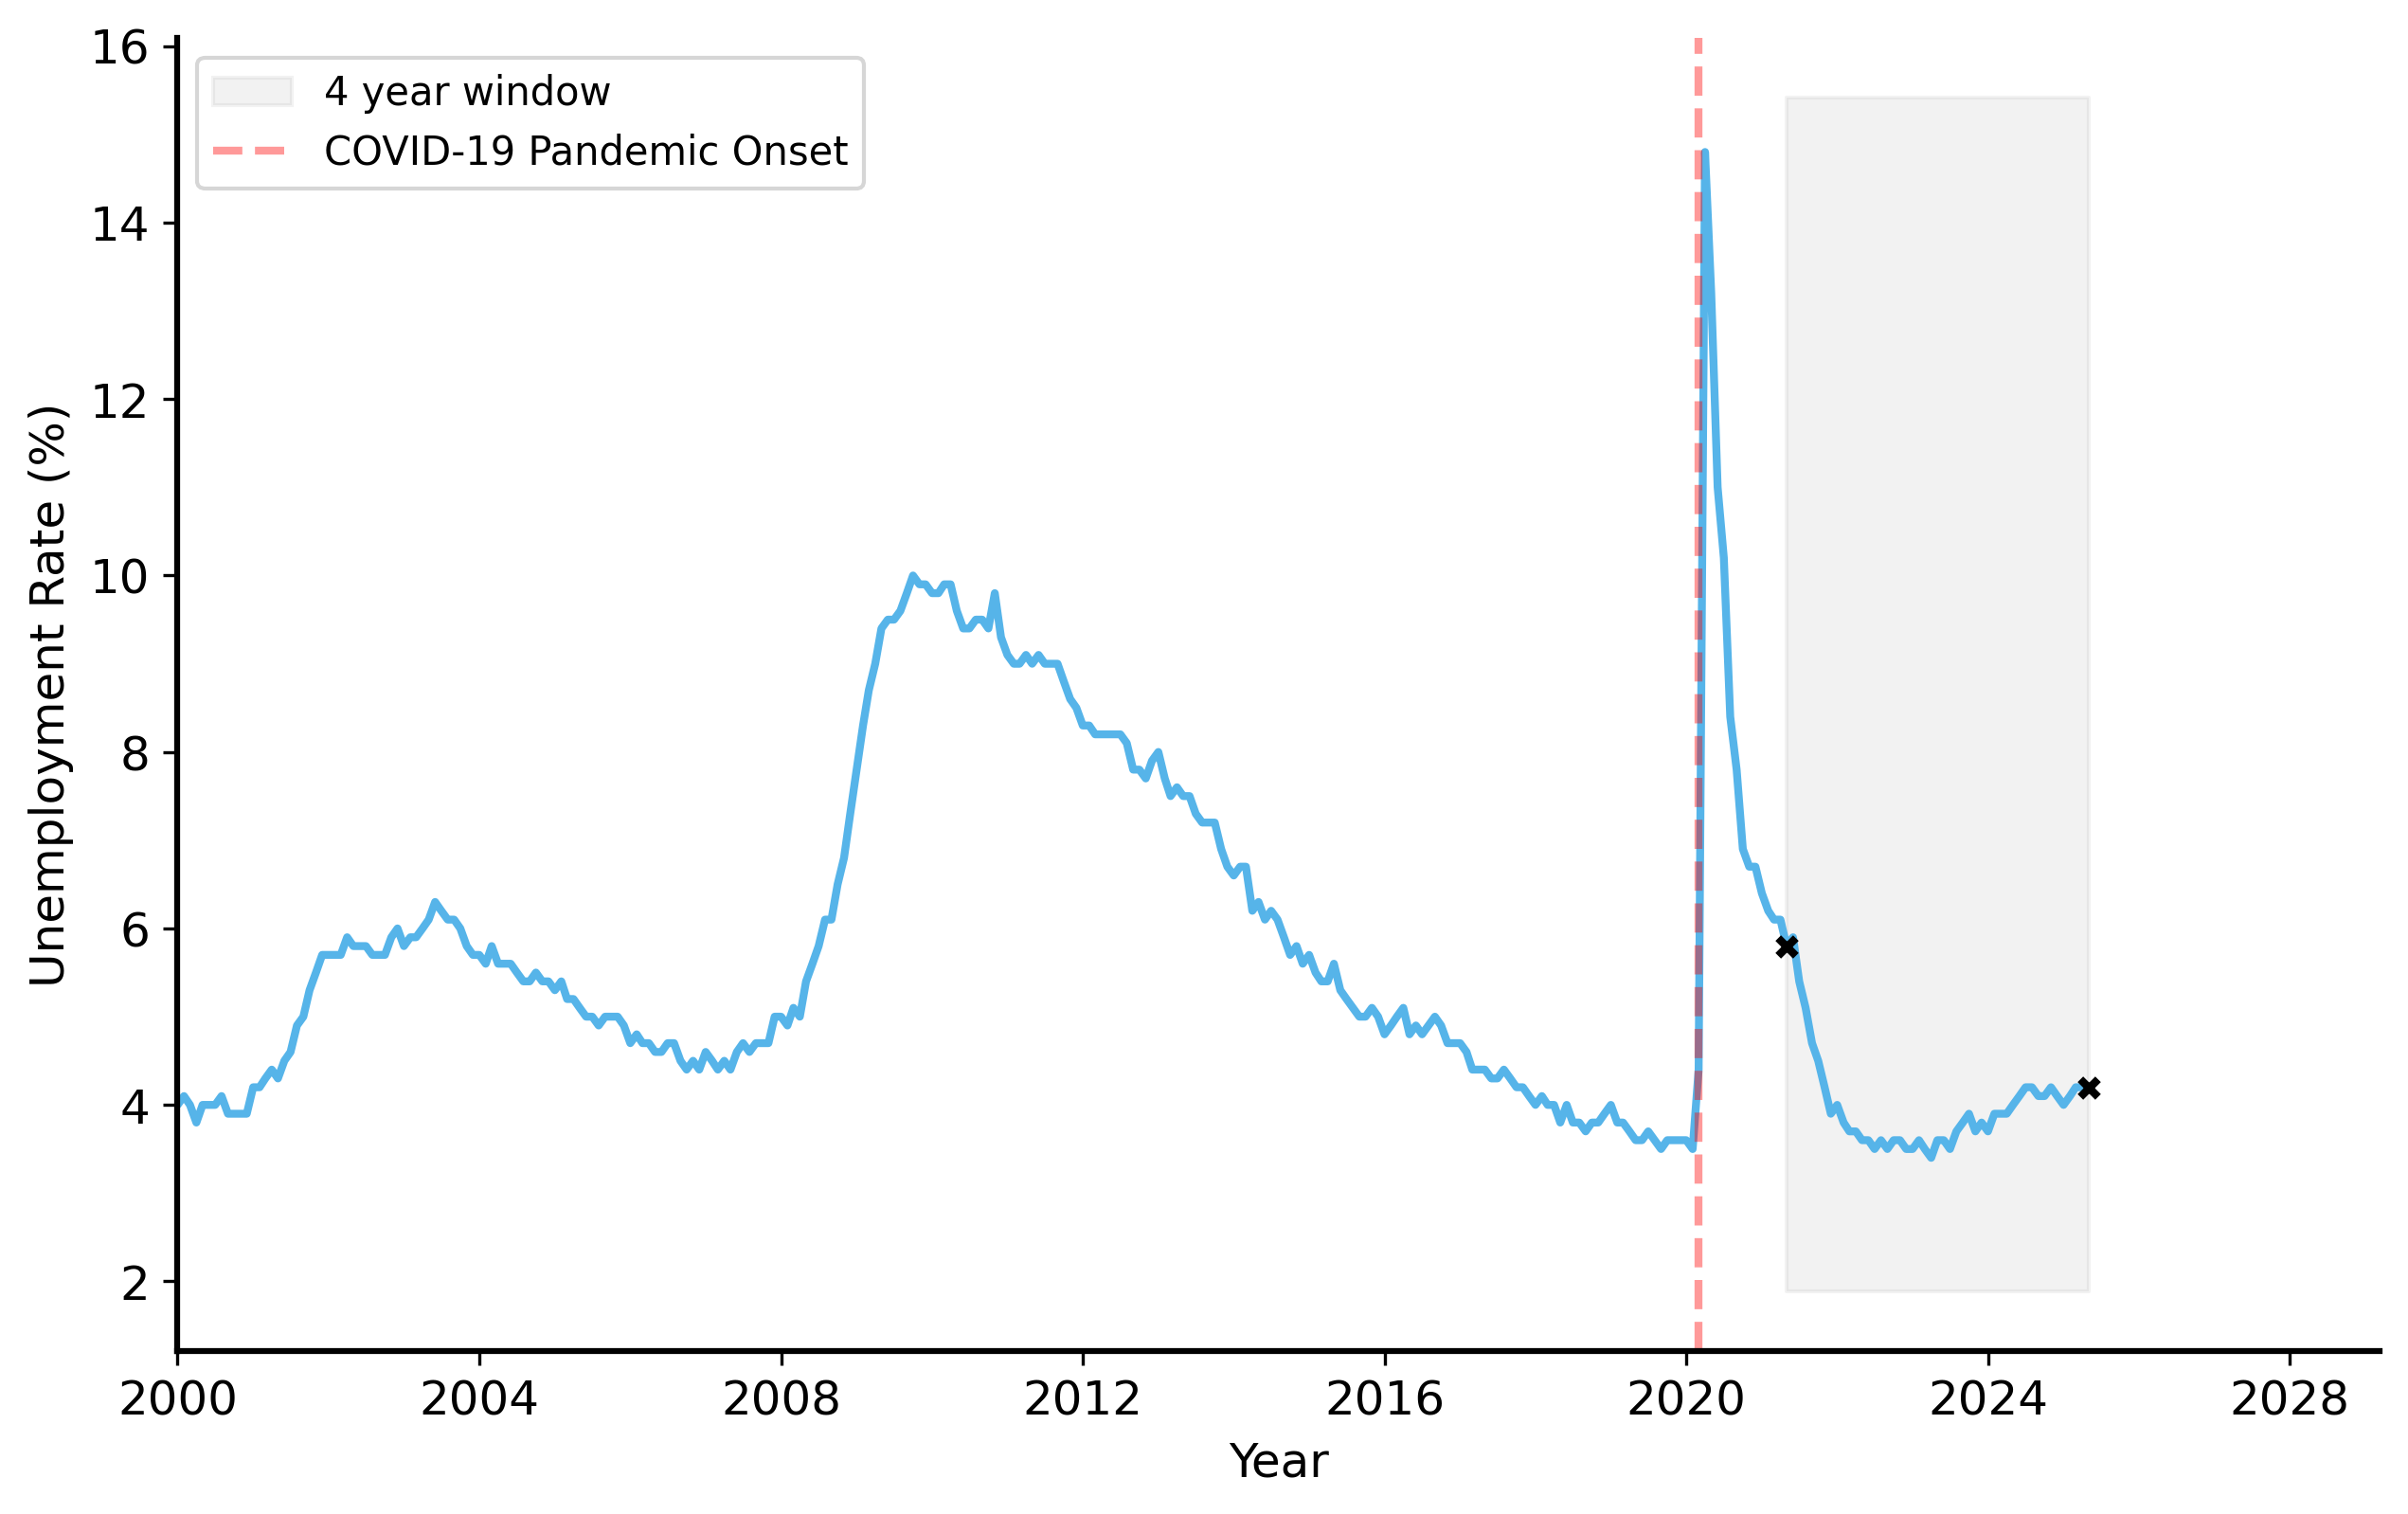

In [5]:
# plot the unemployment data
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=wide_data, x="date", y="seas-unemployment-all", ax=ax)
ax.fill_betweenx(
    ax.get_ylim(),
    datetime.datetime(2021, 5, 1),
    datetime.datetime(2025, 5, 1),
    color="gray",
    alpha=0.1,
    label="4 year window"
)
plt.scatter(
    x=[datetime.datetime(2021, 5, 1), datetime.datetime(2025, 5, 1)],
    y=[wide_data.loc[datetime.datetime(2021, 5, 1), "seas-unemployment-all"], wide_data.loc[datetime.datetime(2025, 5, 1), "seas-unemployment-all"]],
    color="black",
    s=20, zorder=2, marker='x'  
)
ax.axvline(datetime.datetime(2020, 3, 1), color="red", alpha=0.4, linestyle="--", label="COVID-19 Pandemic Onset")
ax.set_xlim(datetime.datetime(2000, 1, 1), None)
ax.set_ylabel("Unemployment Rate (%)")
ax.set_xlabel("Year")
ax.legend()
plt.show()

Hmmm. Suddenly the data looks a lot less convincing. Unemployment **spiked** in 2020 due to the COVID-19 pandemic, and by 2021 it was not yet back to pre-pandemic levels. This complicates the politician's claim. The decrease in unemployment over the last 4 years is not necessarily due to their policies, but rather a recovery from an unprecedented event.

If you changed the time period you were looking at, you could easily come to a different conclusion. For example, if you looked at the last 3 years or the last 6 years, you would see that unemployment actually increased. 

The key point is that *one should always be skeptical about data presented as evidence*. Data can be manipulated, cherry-picked, or misinterpreted to support a particular narrative. It's especially hard to evaluate the validity of a claim when the data is not presented in a transparent way. Because the world is so complicated, there are almost always alternative explanations for a given observation. In this case, the politician cited statistic can potentially be explained by external factors (like the pandemic) rather than their policies. 

To make matters worse, as we saw in the previous lecture, the data itself is not perfect. There is additional variability in the data generating process that we have not accounted for. You will notice that the unemployment rate is not a smooth line, but rather has some fluctuations. This is at least partly due to the fact that the data is collected from a sample of the population, and there is uncertainty in the estimates. ^[They survey around 50,000 housing units each month. See the BLS's [documentation](https://www.bls.gov/opub/hom/cps/design.htm#sample-size) for more information on the sample size and design of the Current Population Survey, which is used to estimate the unemployment rate.] How do we know that a change in the unemployment rate is not just due to random fluctuations in the data?

The **burden of proof** is on the person making the claim. If you want to convince someone that your claim is true, you need to provide evidence that supports it. 

:::{.callout-note title="Beyond a reasonable doubt?" collapse=true}
In a legal context, the phrase "beyond a reasonable doubt" refers to the standard of proof required to convict a defendant in a criminal trial (in the U.S.). It means that the evidence presented must be so convincing that there is no reasonable doubt left in the mind of a juror about the defendant's guilt. Of course you can never be 100% certain -- perhaps the defendant was being mind-controlled by aliens! -- but the evidence must be strong enough to convince a reasonable person that the defendant is guilty.
Any alternative explanations must be ruled out as implausible. This is a high standard of proof, reflecting the serious consequences of a criminal conviction. If the prosecution fails to meet this standard, the defendant is presumed innocent and acquitted of the charges.

In the context of statistical claims, we apply a similar standard of evidence. "Beyond a reasonable doubt" in our case means that 
the alternative explanations for the data are so unlikely (i.e. the probability of them being true is very small) that a reasonable person would simply ignore them. This is really a subjective judgment that is mostly about risk tolerance. 

What level of uncertainty are you willing to accept? Is it okay to be wrong 10% of the time? 5%? 1%? 0.1%? 
:::

### Formalizing hypotheses

One way to increase the transparency of empirical claims is to formalize them as hypotheses. A hypothesis is a specific, testable statement about observed variables. This helps us clarify exactly what the claim is, and design tests to evaluate it. 

In the U.S. legal system, a defendant is presumed innocent until proven guilty. In statistical hypothesis testing, we apply a similar principle:

Null hypothesis ($H_0$) 
: The null hypothesis that represents the status quo or a baseline assumption. 
We call it a "null" hypothesis because it is often a statement of no effect or no difference. 

Alternative hypothesis (denoted by $H_1$) 
: The alternative hypothesis represents the claim we want to test (in the legal analogy, these are the charges brought against the defendant). It is the so-called "alternative" because it is by definition the logical complement of the null hypothesis (meaning $H_1$ is true whenever $H_0$ is false). If the data provides enough evidence against the null hypothesis, we can <span style="color:red">**reject**</span> it in favor of the alternative hypothesis.

The quantity of interest in hypothesis testing is the **$p$-value**. 

$p$-value 
: the probability of a random process producing a result at least as extreme as the observed data, assuming that the null hypothesis is true.^[This is often phrased as "under the assumption that the null hypothesis is true" or more succinctly "under the null".]

In other words, *p* is just the probability that the null is true and our observed data is a result of randomness / sampling variability. The logic of hypothesis testing is that if the $p$-value is very small, it suggests that the data is unlikely to have occurred under the null hypothesis. In this case, we would <span style="color:red">reject</span> the null hypothesis in favor of the alternative hypothesis.  

To get an intuition for $p$-values, we can visualize a simple example. Let's say that we have a random variable $X$ that follows a normal distribution with unknown mean $\mu$ and standard deviation $\sigma = 1$. We want to test the hypothesis that $\mu = 0$ (the null hypothesis) against the alternative hypothesis that $\mu \neq 0$ (the alternative hypothesis). We take a sample of $X$ and observe that its value is $X_1 = 2.1$. What is the $p$-value?

To get the $p$-value, we need the probability distribution of $X$ under the null hypothesis. Since we assume that $X$ follows a normal distribution with mean $\mu = 0$ and standard deviation $\sigma = 1$, we know that the probability density function (PDF) of $X$ is given by:
$$
f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}
$$

We can plot this function to visualize the null distribution. Then the question is: what is the probability of sampling a value at least as extreme as $X_1 = 2.1$?

The answer, it turns out, is exactly equal to the area under the curve of the null distribution where $|X| \geq 2.1$. These regions are shaded in the figure below.

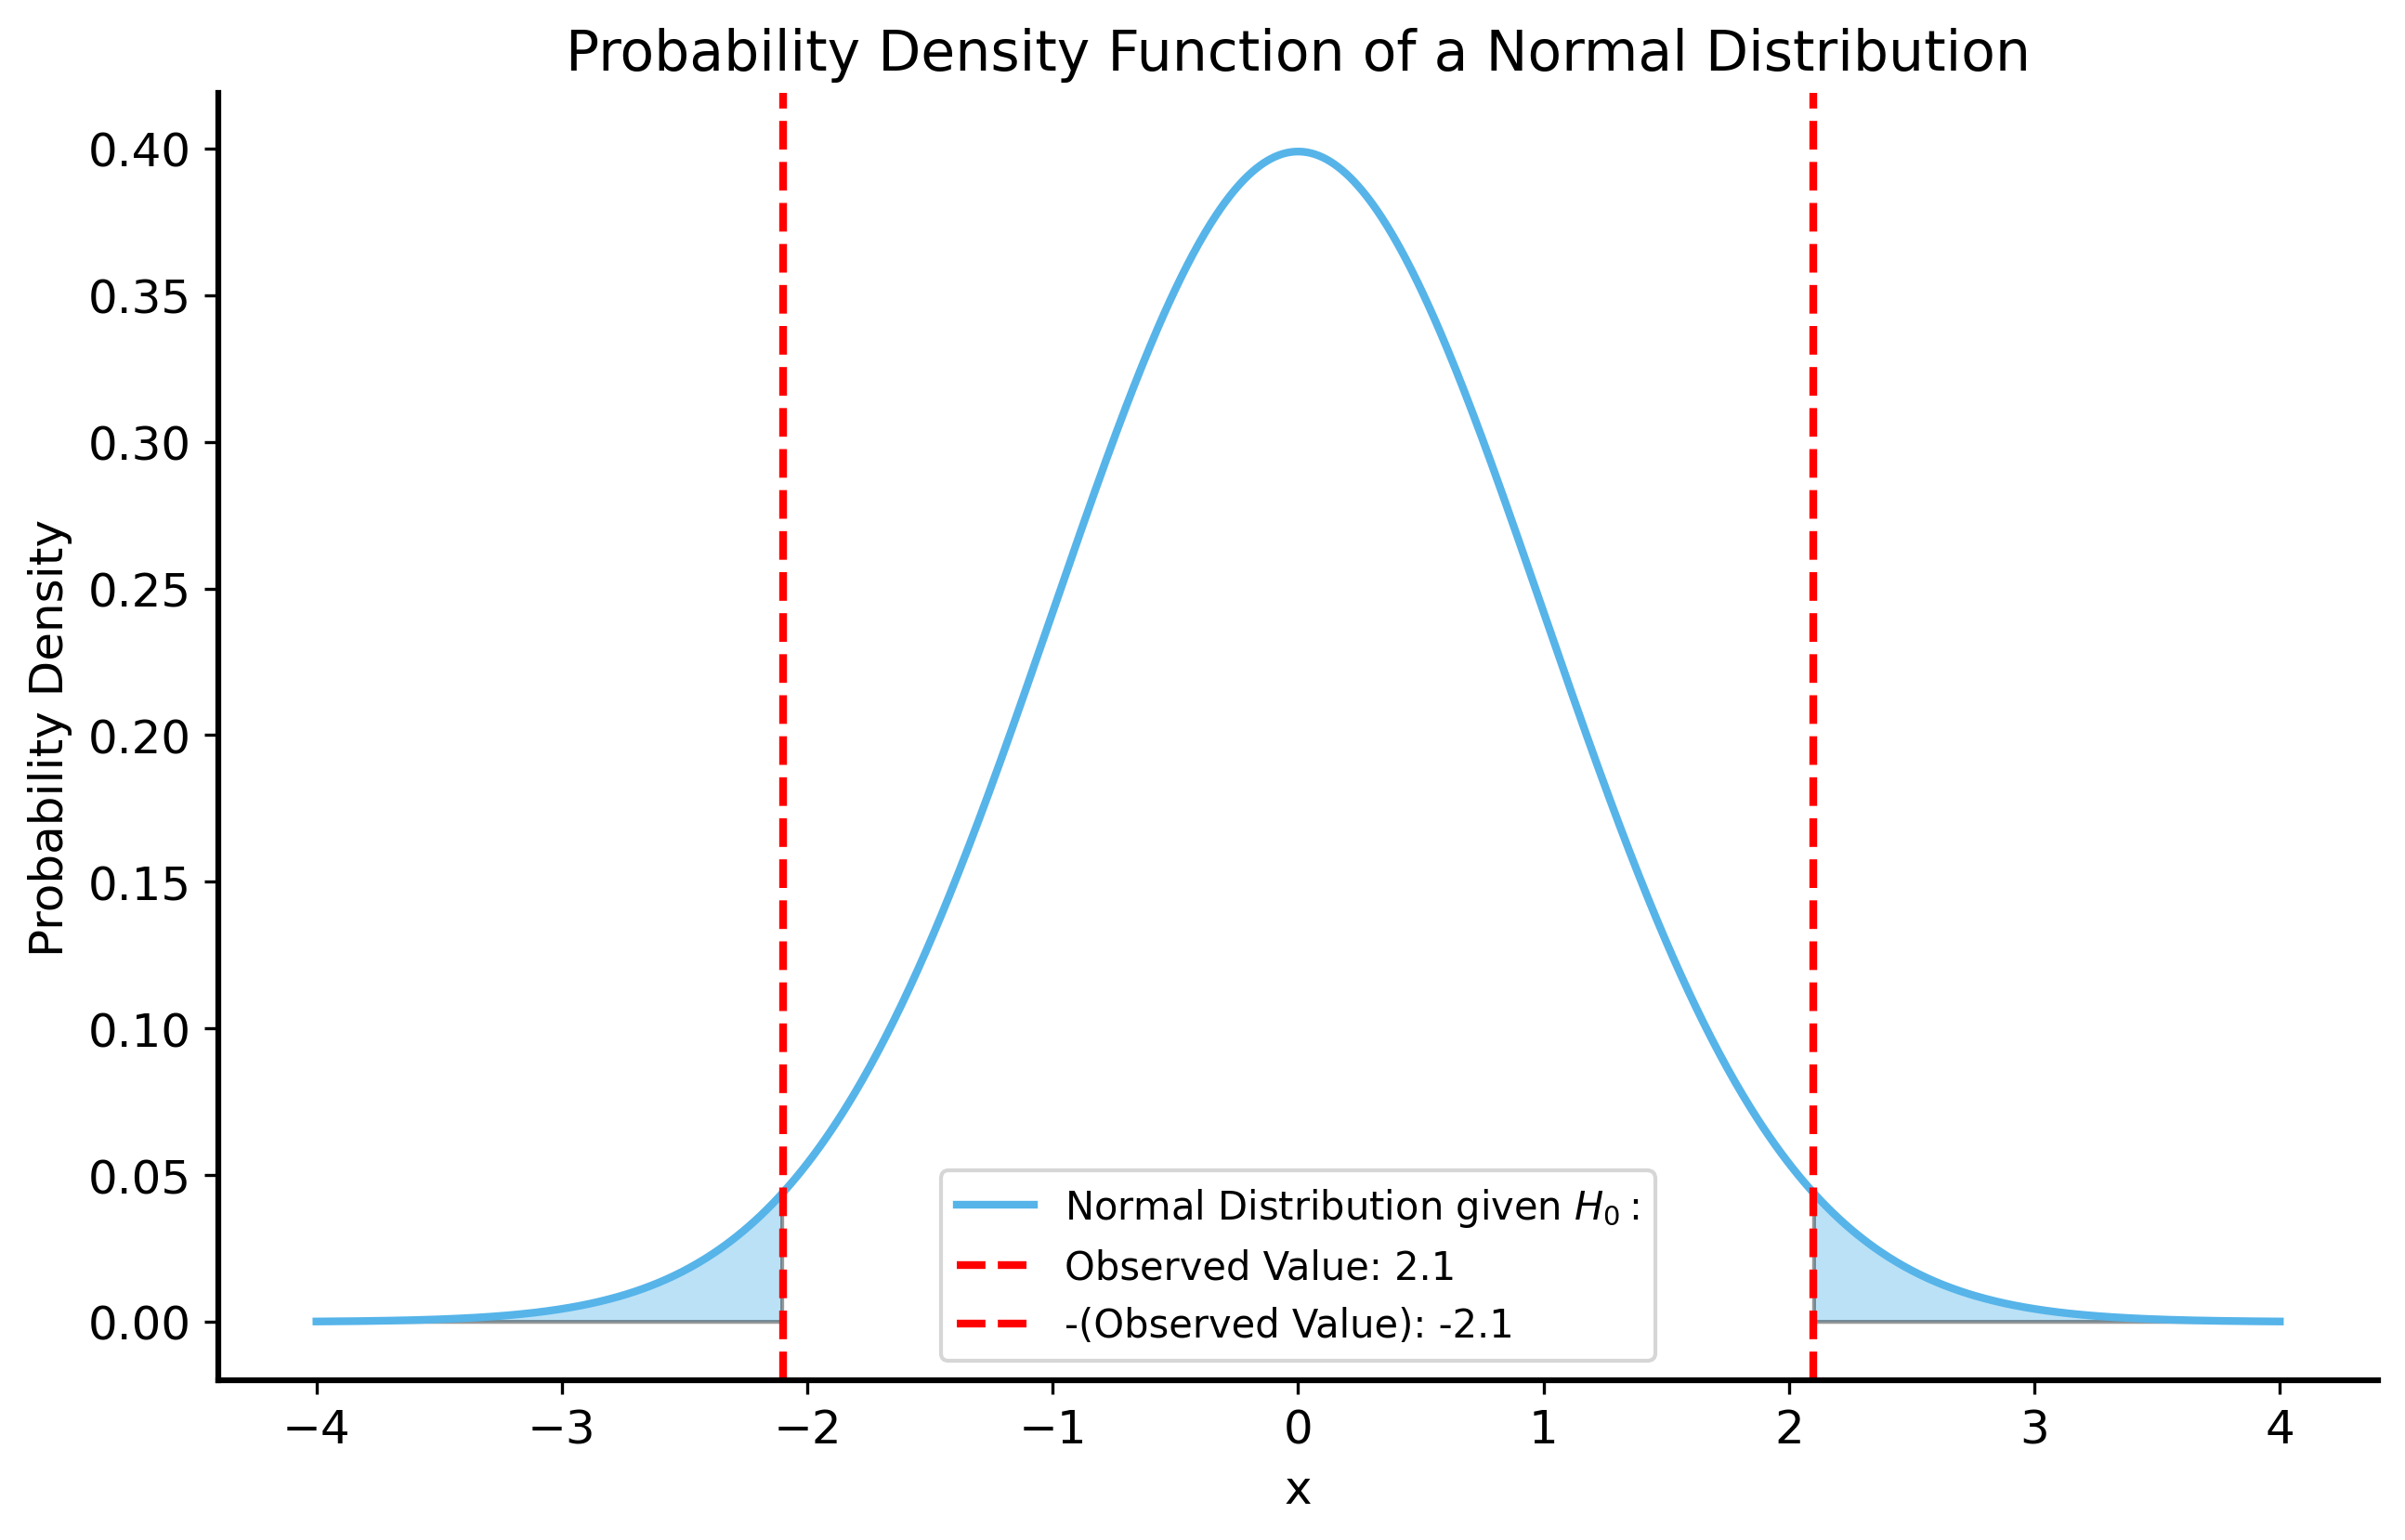

In [6]:
# get pdf of a normal distribution
x = np.linspace(-4, 4, 1000)
# observed value for the hypothesis test
observed = 2.1
null_pdf = stats.norm.pdf(x, loc=0, scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, null_pdf, label=r"Normal Distribution given $H_0:$")
ax.axvline(observed, color="red", linestyle="--", label=f"Observed Value: {observed}")
ax.axvline(-observed, color="red", linestyle="--", label=f"-(Observed Value): {-observed}")

# fill the area under the curve for the null hypothesis
ax.fill_between(x, null_pdf, where=(x >= observed)|(x <= -observed), alpha=0.4)
# ax.fill_between(x, null_pdf, where=(x <= -observed), alpha=0.4)
ax.set_title("Probability Density Function of a Normal Distribution")
ax.set_xlabel("x")
ax.set_ylabel("Probability Density")
ax.legend()
plt.show()


Recall that the area under the curve of a PDF represents the probability of the random variable falling within a certain range. So the $p$-value in many cases can be computed as the area under the PDF of the null distribution where the observed data is at least as extreme as the observed value. 

::: {.callout-note title="Statistical significance" collapse=true}
The $p$-value is often compared to a pre-specified threshold for "significance" (denoted by $\alpha$). This number is essentially your risk tolerance: it represents the maximum probability of incorrectly rejecting the null hypothesis.

If $p < \alpha$, we say that the result is statistically significant.

If $p \geq \alpha$, we say that the result is not statistically significant.

Often in practice, $\alpha$ is set to 0.05, meaning that we are willing to accept a 5% chance of incorrectly rejecting the null hypothesis. In our legal analogy, this would mean that we are willing to convict the defendant if there is only a 5% chance that they are actually innocent. 

The threshold for significance is pretty arbitrary, and it is often set based on convention rather than a careful consideration of the specific context. It is typically better to report the $p$-value itself, rather than just saying whether the result is significant or not. This way, you can see how strong the evidence is against the null hypothesis, rather than just a binary decision.
:::

A few important notes:

- $H_0$ and $H_1$ should be mutually exclusive: if one is true, the other must be false. Otherwise, you cannot make a clear decision about which hypothesis is supported by the data.
- $H_0$ and $H_1$ should be exhaustive: one of them must be true (there are no other possibilities). Again, this helps us avoid a situation where *neither* hypothesis is supported by the data.

Furthermore, hypothesis testing does not provide absolute certainty. Instead, it provides a framework for making decisions based on the evidence at hand. 

- If we fail to <span style="color:red">reject</span> the null hypothesis, it does not necessarily mean that it is true or that we believe it to be true. It simply means that the data does not provide enough evidence to reject it, and accordingly we *act as if* it is true.
- If we <span style="color:red">reject</span> the null hypothesis, we cannot say that the alternative hypothesis is true with absolute certainty. We can only say that the data provides strong evidence against the null hypothesis, and therefore we <span style="color:blue">accept</span> the alternative hypothesis as a likely explanation for the data.

For this reason, we encourage **always reporting the $p$-value** when discussing hypothesis tests. The $p$-value provides a sense of how much uncertainty you have in your conclusion. 

::: {.callout-warning title="Choosing a null hypothesis" collapse=true}
Choosing an appropriate null hypothesis is a crucial step in hypothesis testing. The best way to think about this is to consider the null hypothesis as the baseline you're comparing your data against. 

For a rough claim like "Joey is good at soccer", a possible null hypothesis could be "Joey's soccer skills are no better than the average person." This would be a pretty easy baseline to beat,  since most people do not play soccer much. If Joey plays soccer regularly, he is likely to be better than the average person.

Instead, you might want to compare Joey's skills to a more relevant group, like other players in his league. In that case, the null hypothesis could be "Joey's soccer skills are no better than the average player in his league." This is a much more challenging baseline to beat, since the average player in the league is likely to be more skilled than the average person.

The null hypothesis you choose has a big impact on how we should interpret the results of the hypothesis test. 
:::

### A worked example: the rigged coin
Let's return to the argument with your roommate from the last lecture. Your roommate has made an unproven claim that you are flipping a rigged coin in your favor. 
#### Define the null and alternative hypotheses
We can formalize this as a hypothesis test:

- **$H_0$** (null): The coin is fair, at worst (i.e. the probability of heads is greater than or equal to 0.5).
- **$H_1$** (alternative): The coin is rigged (i.e. the probability of heads is **less than** 0.5).


Note that $H_1$ and $H_0$ are mutually exclusive. If the coin is fair, it cannot be rigged, and vice versa. Moreover, the two hypotheses are exhaustive: either the coin is fair or it is rigged, it cannot be neither. 

Our default assumption (the null) is that the coin is fair (typical coins in circulation are not rigged), and we will only <span style="color:red">reject</span> this assumption if the data provides strong evidence that tails are favored over heads.

::: {.callout-note title="One-sided vs two-sided tests" collapse=true}
Note that we are only interested in whether the coin is rigged in favor of tails, not whether it is rigged in favor of heads. This is because the claim your roommate wants to prove is that you are flipping a rigged coin in your favor, which implies that the probability of heads is less than 0.5. If this probability is greater than or equal to 0.5, then the coin is rigged in his favor -- surely he wouldn't complain about that! 

This is an example of a **one-sided test**. In a one-sided test, we only consider one direction of the alternative hypothesis (in this case, that the coin is rigged in favor of tails).

In contrast, a **two-sided test** would consider both directions of the alternative hypothesis (i.e. that the coin is rigged in favor of heads or tails). In this case, we would have to reject the null hypothesis if the probability of heads is either less than 0.5 or greater than 0.5. We saw this in the example with the normal distribution above, where we were testing whether the mean was equal to 0 or not.
:::

#### Simulate the null distribution
So how do we actually compute the $p$-value? This is where the **sampling and simulation** come into play. We will simulate the process of flipping a fair coin many times, and then see how often we get a result at least as extreme as the one we observed (getting 3 heads out 10). This will give us a **sampling distribution** of the proportion of heads we would expect to see if the coin is fair.

Sampling distribution
: The distribution of a statistic (like the number of heads in 10 coin flips) computed from many repeated samples of the same size from the same population

We will use the sampling distribution as a proxy for the null distribution for our hypothesis test.

First 10 values of greater_than_observed:
 [False  True False False False False False False False False]
First 10 values of greater_than_observed (as integers):
 [0 1 0 0 0 0 0 0 0 0]
p-value: 0.1702


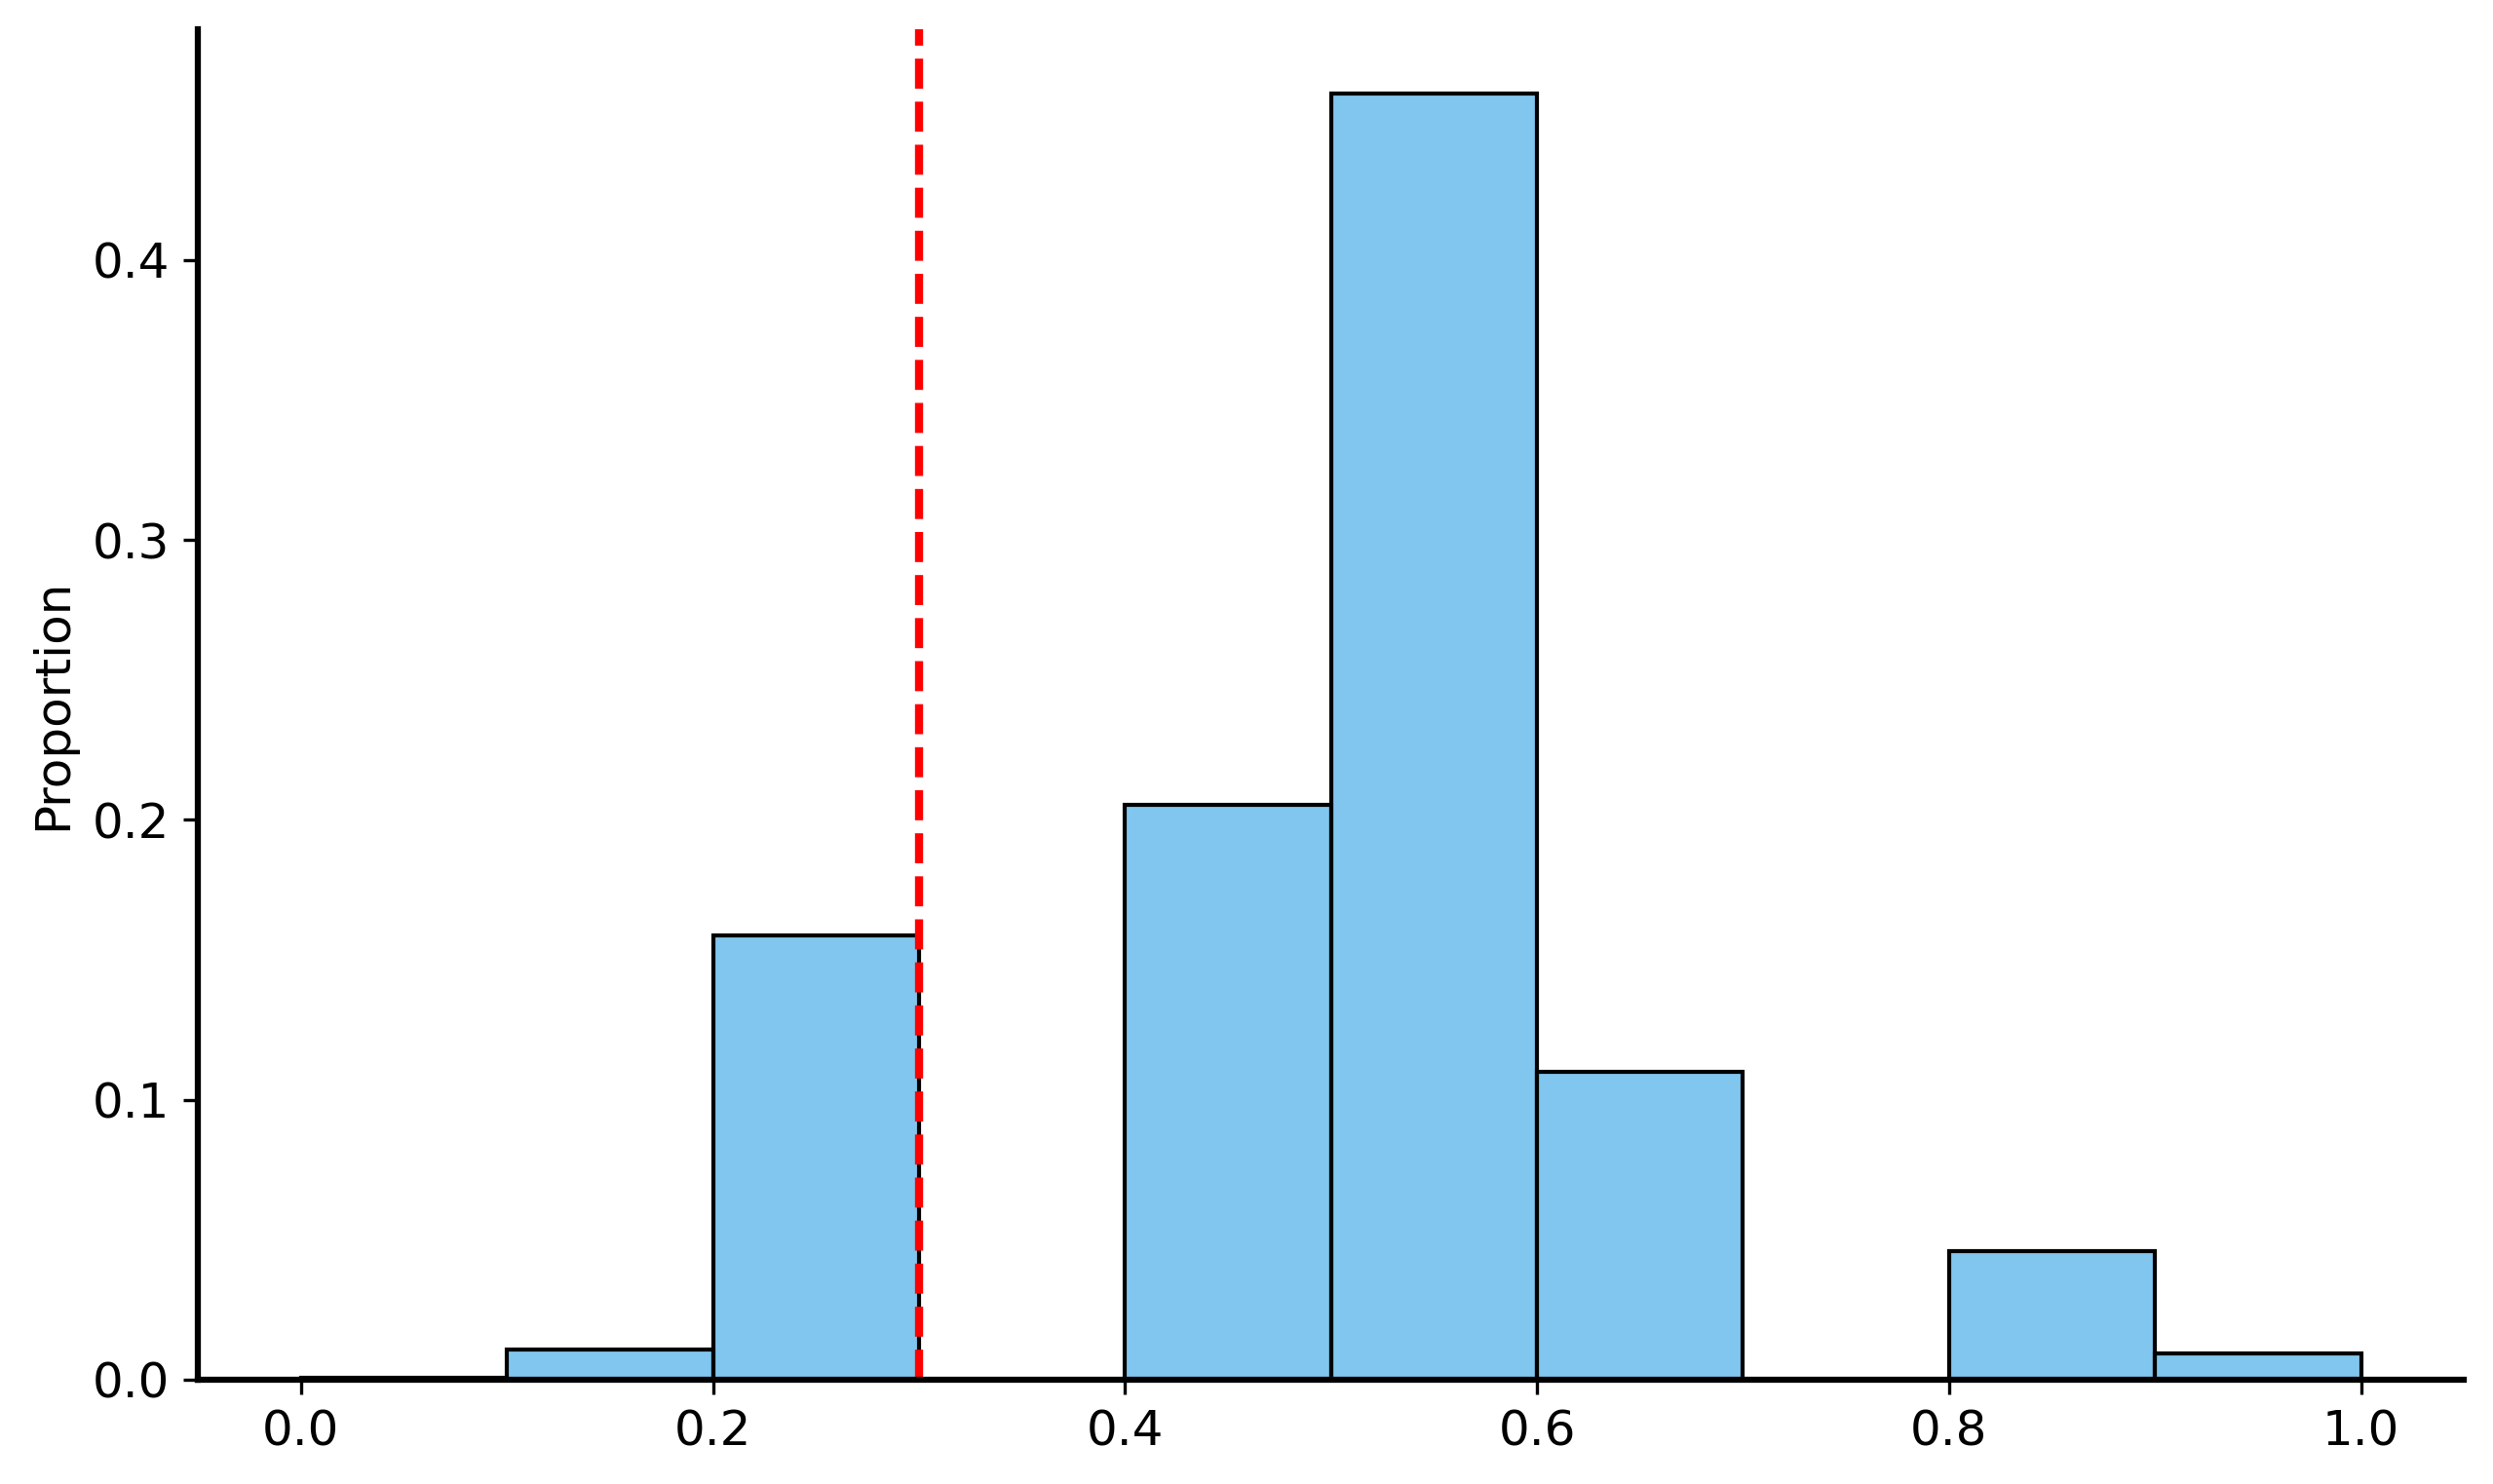

In [7]:
rng = np.random.default_rng(56)  # for reproducibility
n_sims = 10000 # number of simulations
n_flips = 10 # number of coin flips in each simulation
prob_heads = 0.5 # probability of heads for a fair coin
# Initialize a list to store the proportions of heads
proportions = []
for i in range(n_sims):
    # Simulate flipping a fair coin 10 times
    flips = rng.binomial(n=n_flips, p=prob_heads)
    # Store the proportion of heads
    proportions.append(flips / n_flips)
proportions = np.array(proportions) # convert to numpy array
greater_than_observed = proportions <= 0.3 # boolean array 
print("First 10 values of greater_than_observed:\n", greater_than_observed[:10]) # print first 10 values
print("First 10 values of greater_than_observed (as integers):\n", greater_than_observed.astype(int)[:10]) # print first 10 values as integers (0 or 1)
p_value = np.mean(greater_than_observed) # compute the p-value
print("p-value:", p_value)

# plot the histogram of the proportions
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(proportions, bins=10, stat="proportion", ax=ax)
# add a vertical line for the observed value
ax.axvline(0.3, color="red", linestyle="--", label="Observed Proportion: 0.3")

Now we can see that the probability of getting 3 heads out of 10 flips of a fair coin is approximately 0.17! That's not small at all, so your roommate does not have much evidence to support their claim.


## A worked example: The NBA's most valuable player (MVP)
"[Shai Gilgeous Alexander](https://en.wikipedia.org/wiki/Shai_Gilgeous-Alexander) (SGA) is the best player in the NBA" is a very broad claim that is hard to test. What makes a player "the best"? Does stating that they scored the most points make them the best? That his team won the most games?

Let's try to instead design a hypothesis that is more specific and testable. We can choose a specific metric to evaluate players, such as points per game (PPG). You can care about other metrics, like assists or rebounds, but let's just focus on PPG for now.

To make the claim more specific and testable, we'll start off with some assumptions:
- Every player's scoring follows a distribution with some mean $\mu$ and standard deviation $\sigma$. Becuase PPG is an average over the points scored in each game, the CLT tells us that the distribution of average PPG is approximately normal (even if "points scored" is not). Specifically, PPG is a normal distribution with mean $\mu$ and standard deviation $\sigma / \sqrt{n}$, where $n$ is the number of games played.
- The player with the highest $\mu$ is the best scorer in the league (i.e. assume that teammates, coaches, conferences, etc. are all negligible).

To make the claim that SGA is a better scorer than his competitors, we need to show how unlikely it is that he has the highest scoring average if his skill level is not actually the highest in the league.

$H_0$: $\mu_{\text{SGA}} \leq c$

$H_1$: $\mu_{\text{SGA}} > c$

All of a sudden, this is way more familiar, specific, and testable. We can now use data to compute the $p$-value for this hypothesis test.

Shai scored 32.7 PPG in 76 games the 2024-2025 season, which is the highest average in the league. 
The next-highest scorer was Giannis Antetokounmpo with 30.4 PPG in 72 games.

We will use data from the 2024-2025 NBA season, courtesy of [Basketball Reference](https://www.basketball-reference.com/), to evaluate our hypothesis.

Shai's PPG is 32.68 with a standard deviation of 7.54.
Giannis's PPG is 30.39 with a standard deviation of 7.32.


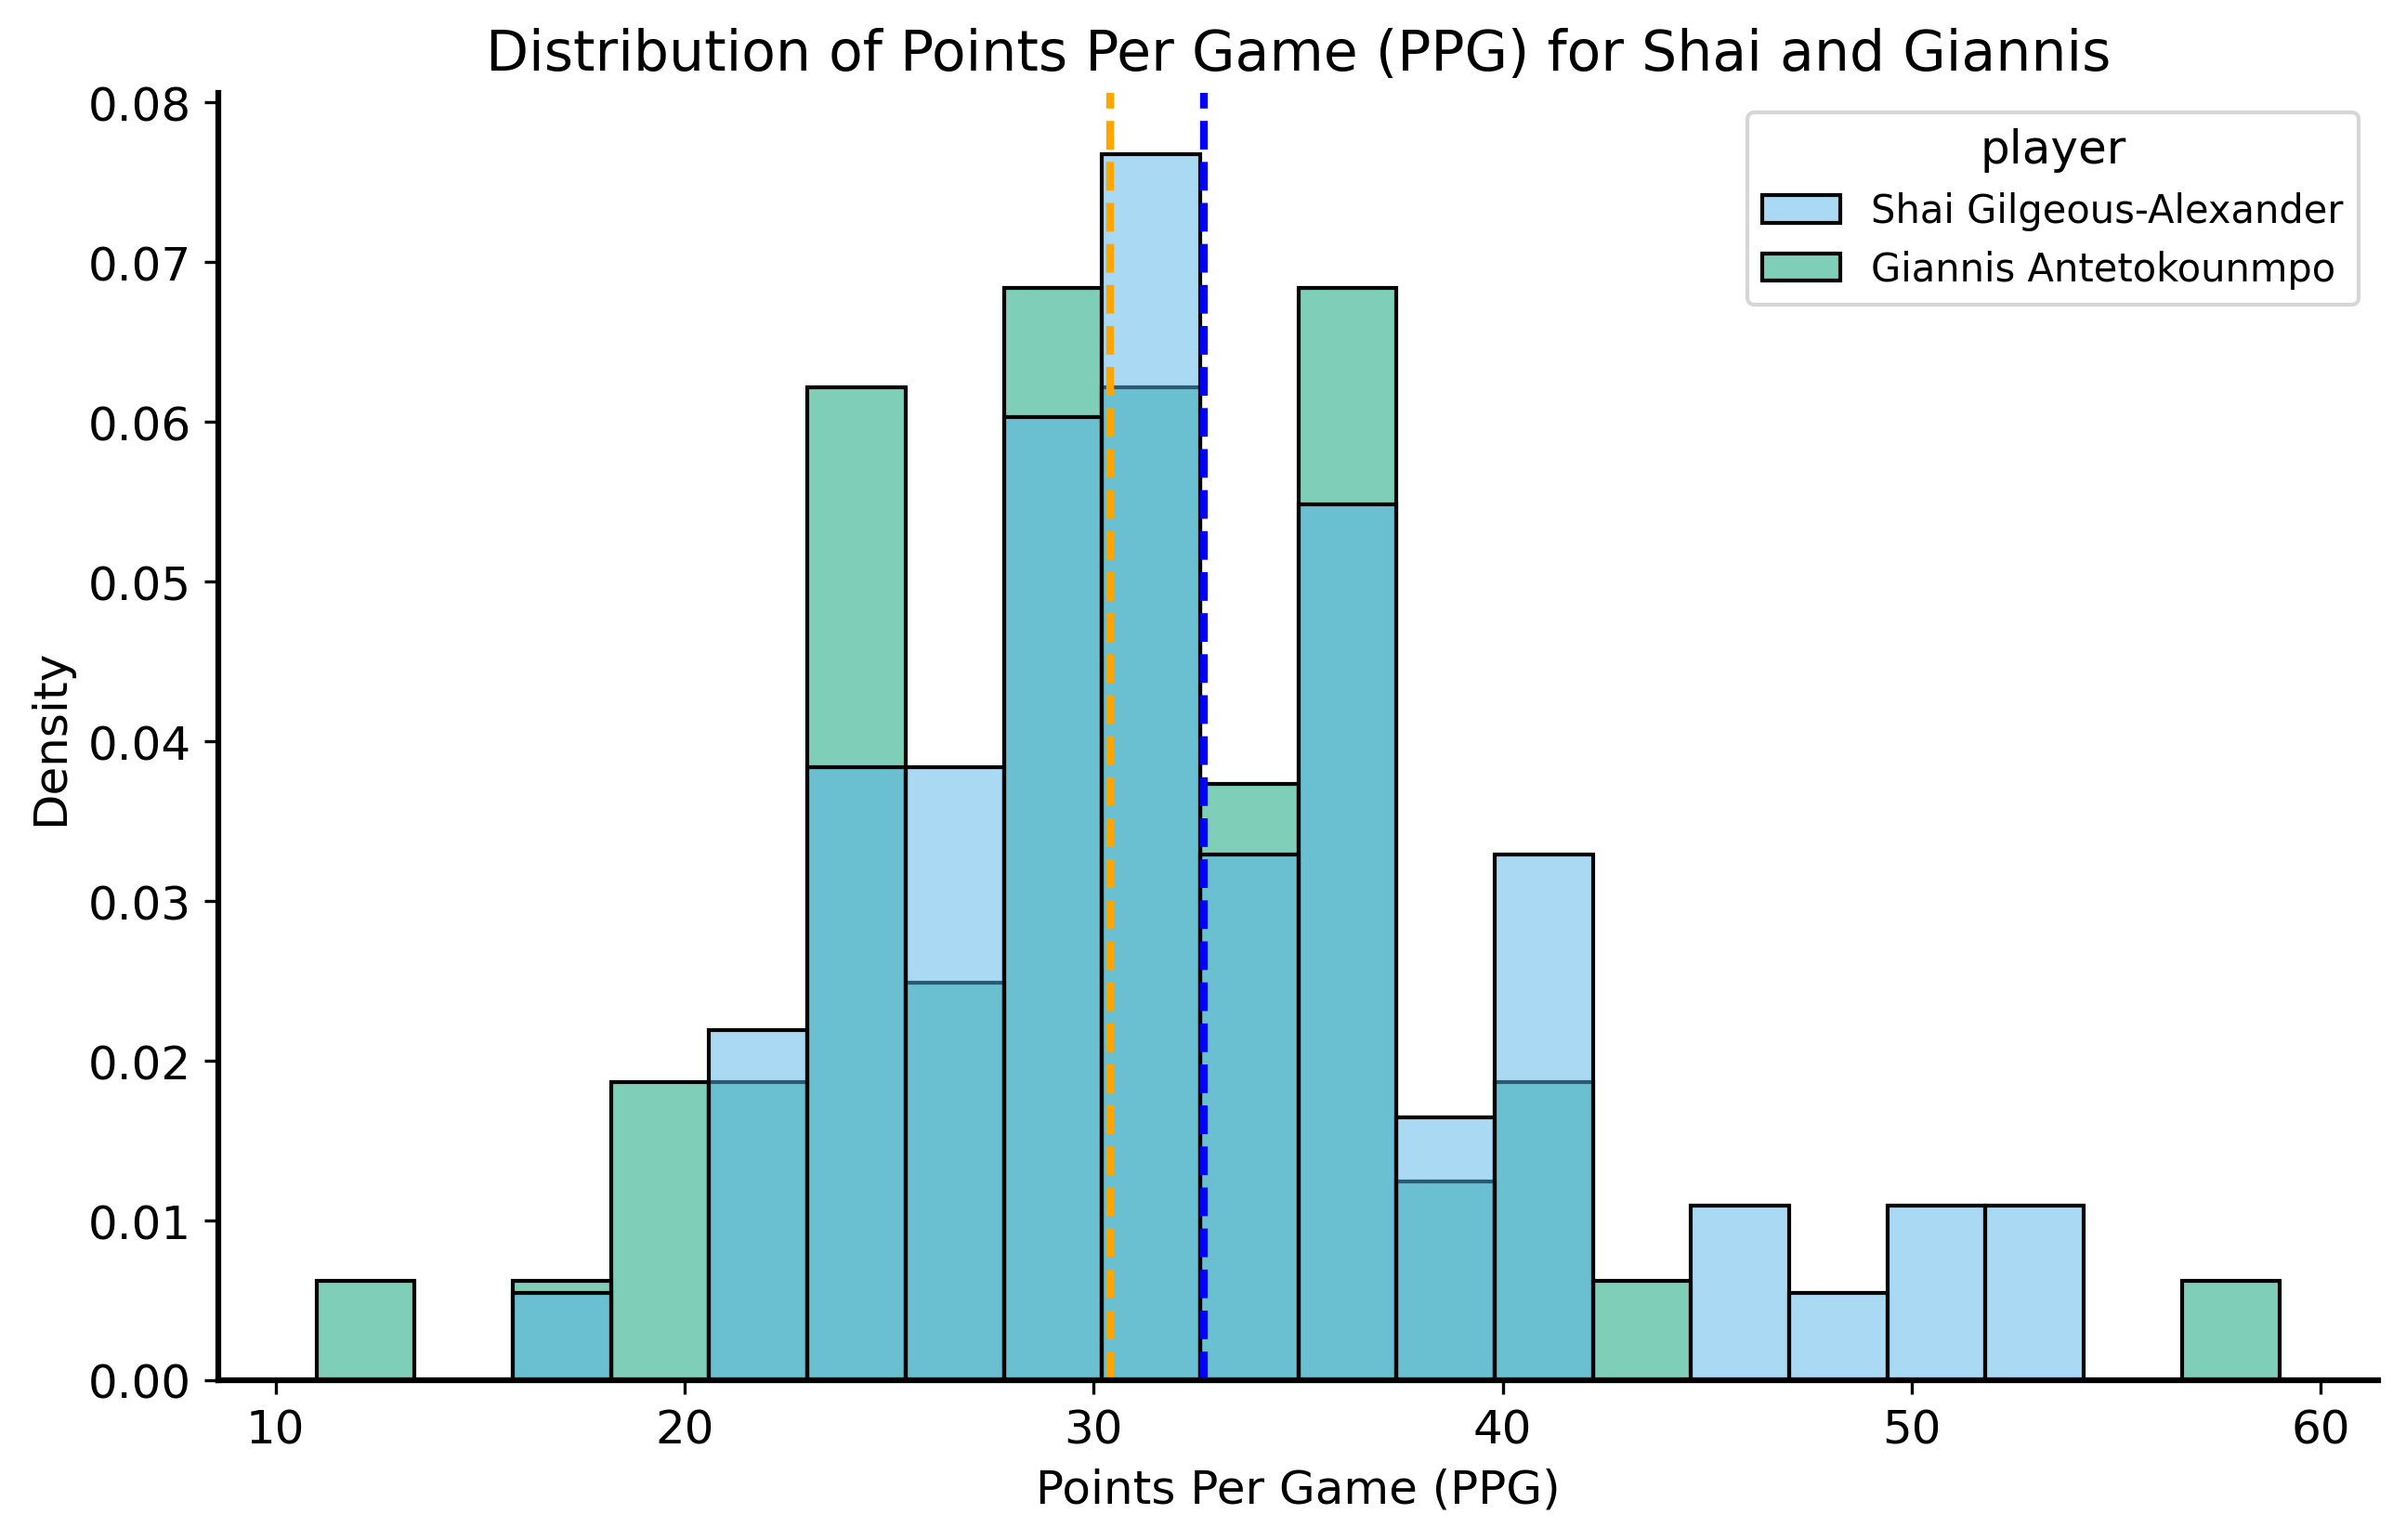

In [51]:
# read the data for Shai Gilgeous-Alexander and Giannis Antetokounmpo
sga_df = pd.read_csv("../data/sga-stats-24-25.csv")
giannis_df = pd.read_csv("../data/giannis-stats-24-25.csv")
# combine the dataframes and clean up the data
sga_df["player"] = "Shai Gilgeous-Alexander"
giannis_df["player"] = "Giannis Antetokounmpo"
compare_df = pd.concat([sga_df, giannis_df], ignore_index=True)
# filter out rows where the player did not play or was inactive
compare_df = compare_df.replace({"Did Not Dress": np.nan, "Inactive": np.nan, "Did Not Play": np.nan, "": np.nan})
compare_df.dropna(subset=["PTS"], inplace=True)
# convert PTS to float/numeric and Date to datetime
compare_df["PTS"] = compare_df["PTS"].astype(float)
compare_df["Date"] = pd.to_datetime(compare_df["Date"])

shai_sample_mean = compare_df.query("player == 'Shai Gilgeous-Alexander'")["PTS"].mean()
shai_sample_std = compare_df.query("player == 'Shai Gilgeous-Alexander'")["PTS"].std()
print(f"Shai's PPG is {shai_sample_mean:.2f} with a standard deviation of {shai_sample_std:.2f}.")

giannis_sample_mean = compare_df.query("player == 'Giannis Antetokounmpo'")["PTS"].mean()
giannis_sample_std = compare_df.query("player == 'Giannis Antetokounmpo'")["PTS"].std()
print(f"Giannis's PPG is {giannis_sample_mean:.2f} with a standard deviation of {giannis_sample_std:.2f}.")

# plot the distribution of PPG for both players
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=compare_df, x="PTS", hue="player", stat="density", common_norm=False, bins=20, ax=ax)
ax.axvline(shai_sample_mean, color="blue", linestyle="--", label=f"Shai's PPG: {shai_sample_mean:.2f}")
ax.axvline(giannis_sample_mean, color="orange", linestyle="--", label=f"Giannis's PPG: {giannis_sample_mean:.2f}")
ax.set_title("Distribution of Points Per Game (PPG) for Shai and Giannis")
ax.set_xlabel("Points Per Game (PPG)")
plt.show()

Now what is the null distribution? Our null hypothesis is that SGA's scoring ability is not higher than his competitors'. So let's say that under the null, SGA's inherent scoring ability is equal to Giannis's observed PPG of 30.4. That's the mean of our normal distribution given by CLT. For the standard error, we can use the sample standard deviation of Shai's points scored and divide it by the square root of the number of games he played (76). 

Now the question is: what is the probability of SGA scoring at least 32.7 PPG if his true scoring ability is actually 30.4 PPG?

We can just use the normal distribution to compute this probability!

:::{.callout-note title="The Cumulative Distribution Function (CDF)" collapse=true}
The CDF of a normal distribution gives us the probability that a random variable is less than or equal to a certain value.
In other words, it computes are under a probability density function (PDF) up to a certain point. 

To compute the probability of a random variable being greater than a certain value, we can just subtract the CDF from 1.
$$
P(X > x) = 1 - P(X \leq x) = 1 - \text{CDF}(x) = 1 - \int_{-\infty}^{x} f(t) dt
$$
:::

p-value from CLT: 0.00391019858958408


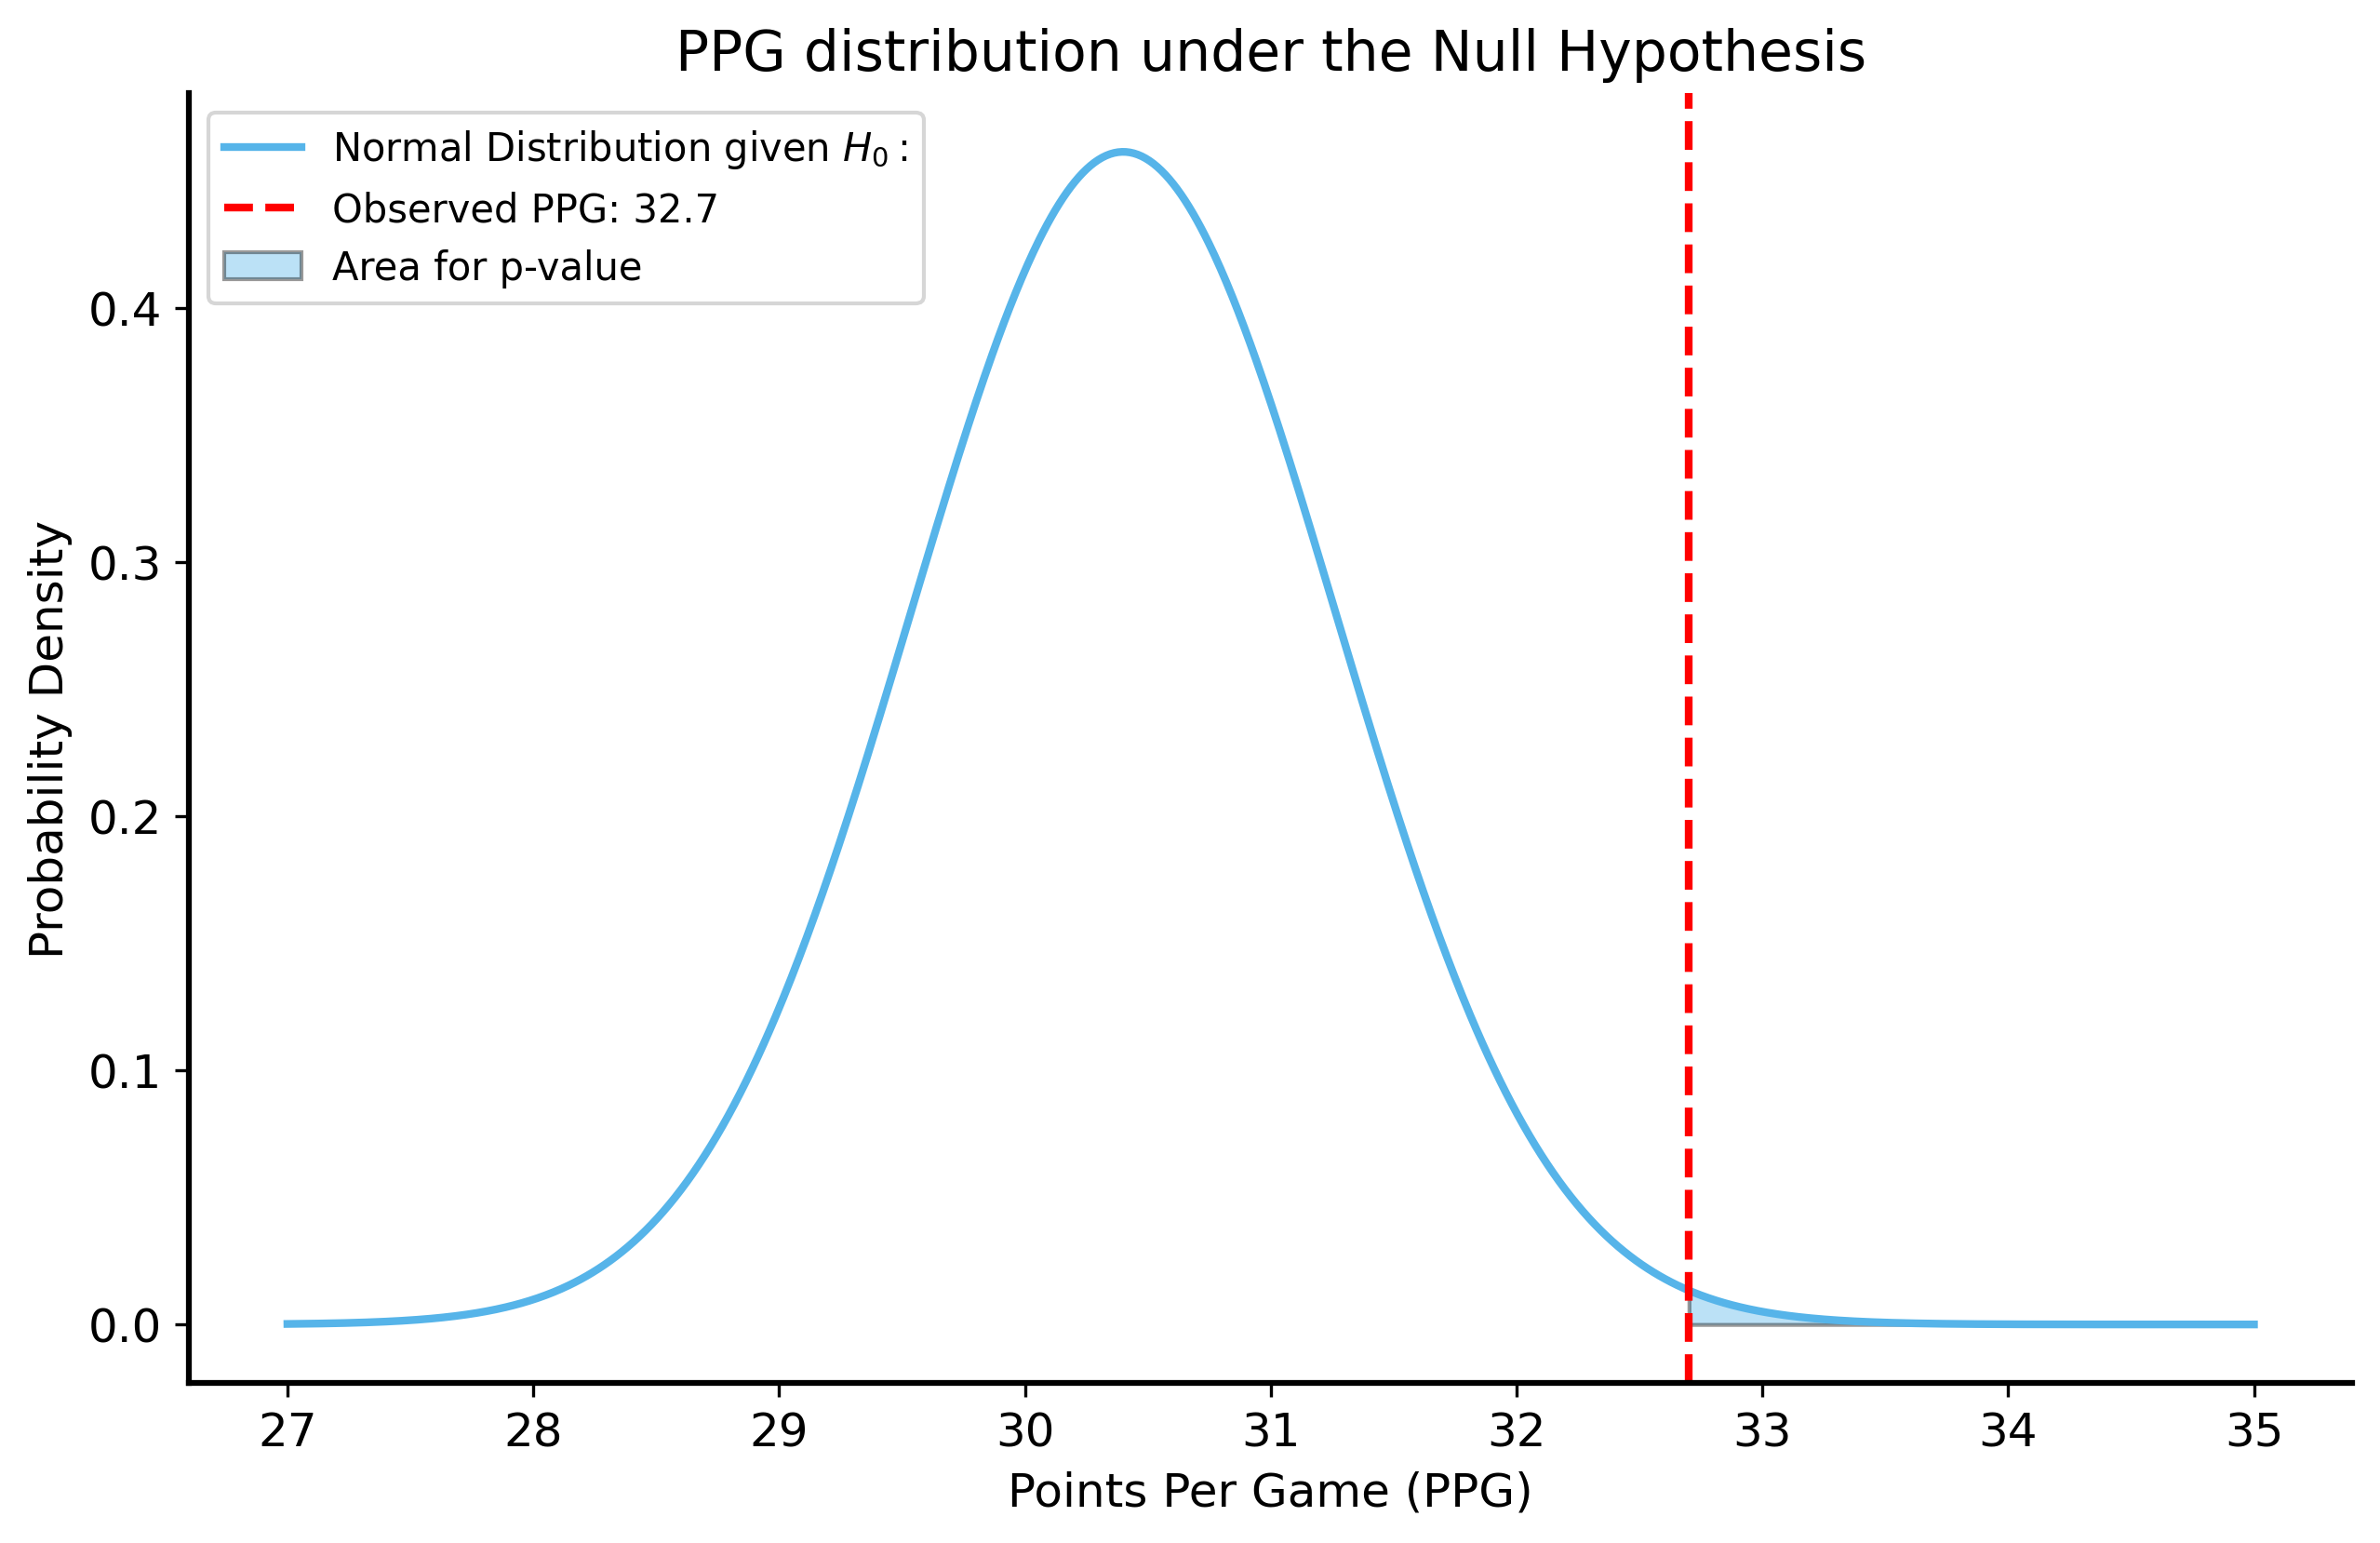

In [43]:
## PDF of normal
shai_n_games = compare_df.query("player == 'Shai Gilgeous-Alexander'")["PTS"].count()
p_value_clt = 1 - stats.norm.cdf(
    x=32.7, 
    loc=30.4, # the mean of the null distribution (Giannis's PPG)
    scale=shai_sample_std/np.sqrt(shai_n_games)) 
print("p-value from CLT:", p_value_clt)
# visualize the p-value
x = np.linspace(27, 35, 1000)
null_pdf = stats.norm.pdf(x, loc=30.4, scale=shai_sample_std/np.sqrt(shai_n_games))
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, null_pdf, label=r"Normal Distribution given $H_0:$")
ax.axvline(32.7, color="red", linestyle="--", label=f"Observed PPG: 32.7")
ax.fill_between(x, null_pdf, where=(x >= 32.7), alpha=0.4, label="Area for p-value")
ax.set_title("PPG distribution under the Null Hypothesis")
ax.set_xlabel("Points Per Game (PPG)")
ax.set_ylabel("Probability Density")
ax.legend()
plt.show()

This analysis tells us that if Shai's true scoring ability is 30.4 PPG, the probability of him scoring at least 32.7 PPG over 76 games is very small. 

We can also try simulating the null distribution through individual game scores to see how likely it is that SGA would score at least 32.7 PPG if his true scoring ability is actually 30.4 PPG. That is, we'll simulate 76 games of scoring, we each game is drawn from a distribution with mean 30.4 and standard deviation equal to the observed sample standard deviation of Shai's points scored. We'll repeat this simulation many times to get a distribution of PPG scores under the null hypothesis. 

p-value from simulation: 0.004


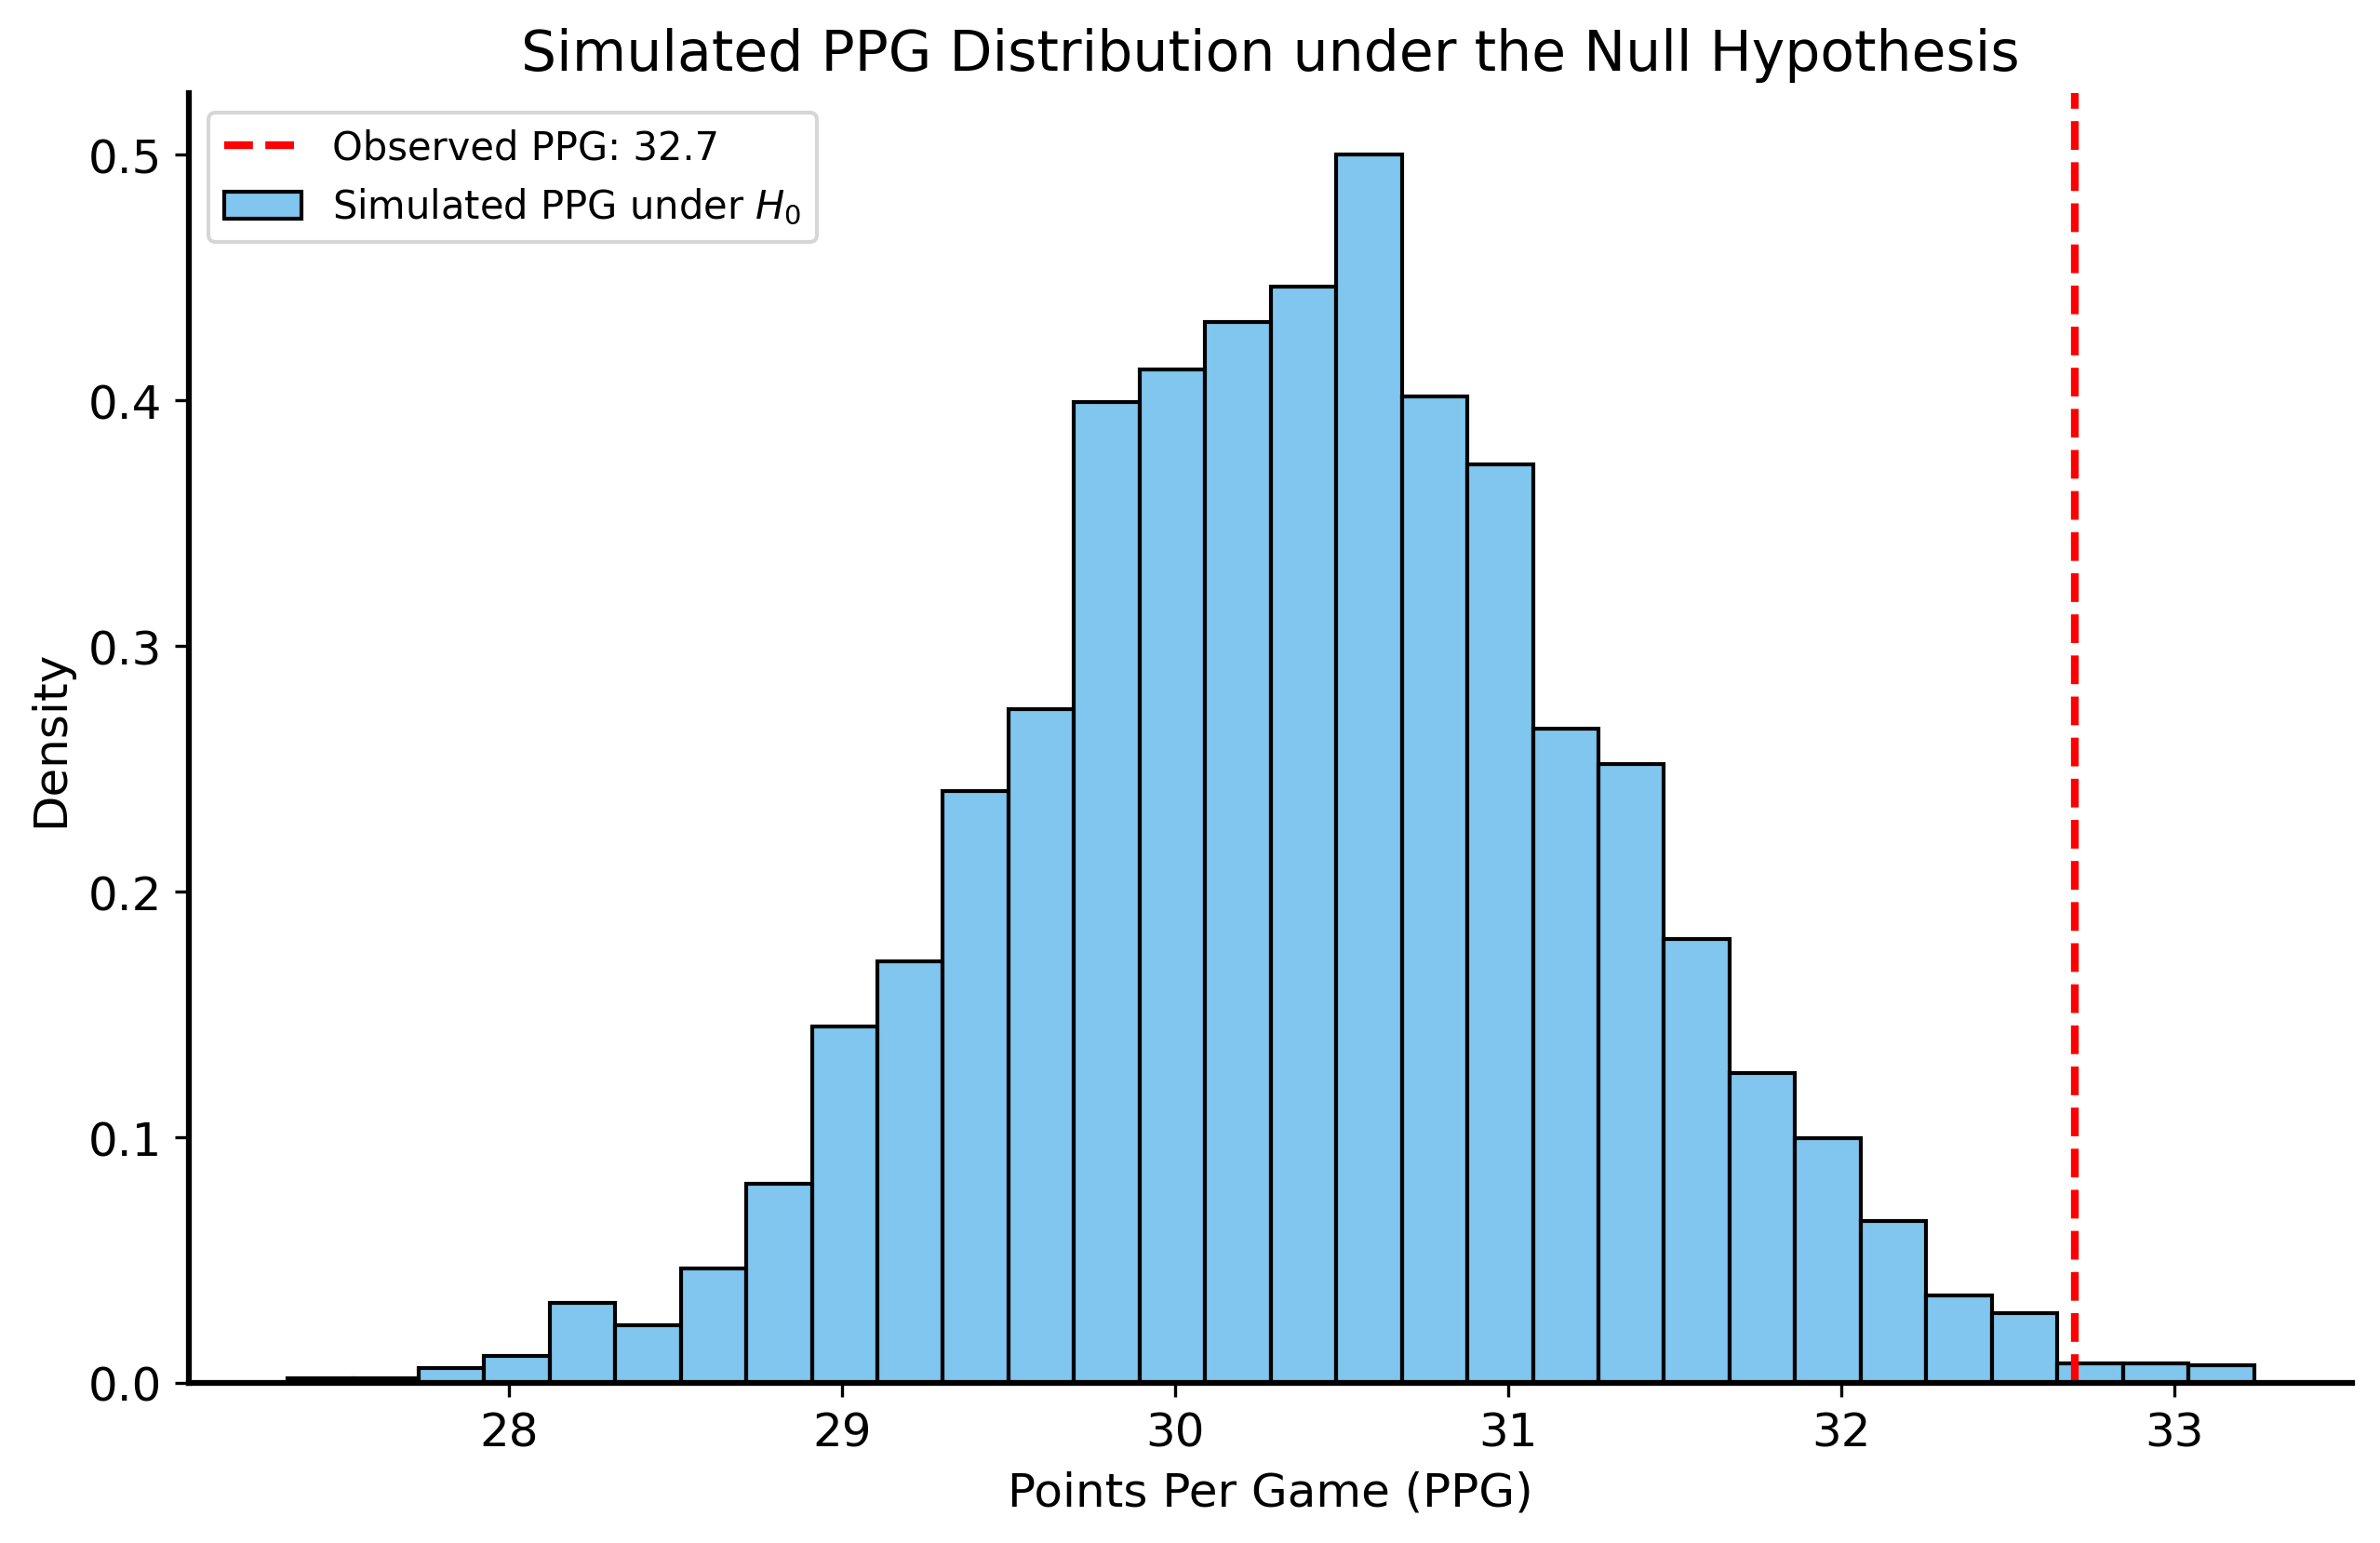

In [ ]:
rng = np.random.default_rng(42)  # for reproducibility
n_sims = 5000
shai_simulated_ppg = []
for _ in range(n_sims):
    # simulate 76 games of scoring, each game is drawn from a distribution with 
    # mean 30.4 and standard deviation equal to the observed sample standard deviation of Shai's points scored
    # Variance of continuous uniform distribution on [a, b] is (b-a)^2 / 12
    low_minus_high = np.sqrt(12 * shai_sample_std**2)
    simulated_scores = rng.uniform(low=30.4 - low_minus_high/2, high=30.4 + low_minus_high/2, size=76)
    simulated_ppg = np.mean(simulated_scores)
    shai_simulated_ppg.append(simulated_ppg)
# compute the p-value from the simulated PPG scores
shai_simulated_ppg = np.array(shai_simulated_ppg)
p_value_simulated = np.mean(shai_simulated_ppg >= 32.7)
print("p-value from simulation:", p_value_simulated)

# plot the distribution of simulated PPG scores
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(shai_simulated_ppg, bins=30, stat="density", ax=ax, label="Simulated PPG under $H_0$")
ax.axvline(32.7, color="red", linestyle="--", label=f"Observed PPG: {32.7}")
ax.set_title("Simulated PPG Distribution under the Null Hypothesis")
ax.set_xlabel("Points Per Game (PPG)")
ax.set_ylabel("Density")
ax.legend()
plt.show()

For this second approach, we didn't use the CLT at all! Instead, we relied on simulation to understand the distribution of Shai's scoring under the null hypothesis. And yet, the results are almost identical to the ones we got using the normal approximation!

Can you think of any limitations of the approach we took? What assumptions did we make that might not be right? Next lecture we'll look at approaches that do not make any assumptions about the distribution of the data, and instead rely on resampling techniques to evaluate hypotheses.

## Errors in hypothesis testing

There are two types of errors that can occur in hypothesis testing:

1. False positive: reject the null hypothesis when it is actually true. 
2. False negative: fail to reject the null hypothesis when it is actually false.

These errors are also known as Type I and Type II errors, respectively.

This is a bit easier undestand if you tabulate the possible outcomes of a hypothesis test:

|  | Reject $H_0$ | Do not reject $H_0$ |
|----------------------|--------------------------|-------------------------------|
| **$H_0$ is true** | Type I error (false positive) | Correct decision |
| **$H_0$ is false** | Correct decision | Type II error (false negative) |

The convention in statistics is to denote the probability of a Type I error (false positive) as $\alpha$ and the probability of a Type II error (false negative) as $\beta$.

In [56]:
#| echo: false
from jupyterquiz import display_quiz

questions = [
    {"question": "You are trying to decide if an economic policy reduces unemployment. You set up an experiment comparing two demographically and statistically similar groups. One group gets the policy change, the other does not. What is the appropriate null hypothesis?",
     "type": "multiple_choice",
     "answers": [
         {"answer": "The policy has no effect on unemployment", "correct": False},
         {"answer": "The policy reduces unemployment", "correct": False},
         {"answer": "The policy increases unemployment", "correct": False},
         {"answer": "The policy either reduces or increases unemployment", "correct": True}
        ]},
    {"question": "Assume your study results in a p-value of 0.12. Since there is a 12\% chance of observing the data if the null hypothesis is true, you decide not to reject the null hypothesis. As it turns out, the policy actually works really well -- many other concurrent studies show that the policy reduces unemployment by 10\%. What kind of error did you make?",
        "type": "multiple_choice",
        "answers": [
            {"answer": "Type I error (false positive)", "correct": False},
            {"answer": "Type II error (false negative)", "correct": True},
            {"answer": "No error, the null hypothesis was correctly not rejected", "correct": False},
            {"answer": "No error, the null hypothesis was correctly rejected", "correct": False}
        ]
    },
    {"question": "Instead assume your study results in a p-value of .00003. True or false: the alternative hypothesis is definitely correct, and the policy reduces unemployment.",
        "type": "multiple_choice",
        "answers": [
            {"answer": "True, the alternative hypothesis is definitely correct", "correct": False},
            {"answer": "False, the alternative hypothesis is not definitely correct", "correct": True}
        ]
    }
]
display_quiz(questions, shuffle_answers=False)

<>:13: SyntaxWarning: invalid escape sequence '\%'
<>:13: SyntaxWarning: invalid escape sequence '\%'
/var/folders/7h/662tdm8d6sn0krrht717wzmm0000gq/T/ipykernel_4223/3460913141.py:13: SyntaxWarning: invalid escape sequence '\%'
  {"question": "Assume your study results in a p-value of 0.12. Since there is a 12\% chance of observing the data if the null hypothesis is true, you decide not to reject the null hypothesis. As it turns out, the policy actually works really well -- many other concurrent studies show that the policy reduces unemployment by 10\%. What kind of error did you make?",


<IPython.core.display.Javascript object>

## Summary

In this lecture, we studied hypothesis testing -- a framework for evaluating claims about data and making data-driven decisions under uncertainty. We learned about the need to formalize claims and quantify uncertainty due to sampling variability, how to establish a null hypothesis, the meaning of the $p$-value, and how to compute it based on sampling distributions.

In the next lecture, we will think about what to do when we don't have any idea about the underlying distribution of the data, which makes it hard to generate sampling distributions. 
